In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

## Data Preparation

### Initial Checks

In [3]:
df = pd.read_excel('Coffee Shop Sales.xlsx')
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [5]:
df.describe()

,transaction_id,transaction_date,transaction_qty,store_id,product_id,unit_price
count,149116.000000,149116,149116.000000,149116.000000,149116.000000,149116.000000
mean,74737.371872,2023-04-15 11:50:32.173609984,1.438276,5.342063,47.918607,3.382219
min,1.000000,2023-01-01 00:00:00,1.000000,3.000000,1.000000,0.800000
25%,37335.750000,2023-03-06 00:00:00,1.000000,3.000000,33.000000,2.500000
50%,74727.500000,2023-04-24 00:00:00,1.000000,5.000000,47.000000,3.000000
75%,112094.250000,2023-05-30 00:00:00,2.000000,8.000000,60.000000,3.750000
max,149456.000000,2023-06-30 00:00:00,8.000000,8.000000,87.000000,45.000000
std,43153.600016,NaN,0.542509,2.074241,17.930020,2.658723


In [6]:
df.isnull().sum()

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

## EDA

#### Daily Sales Trend

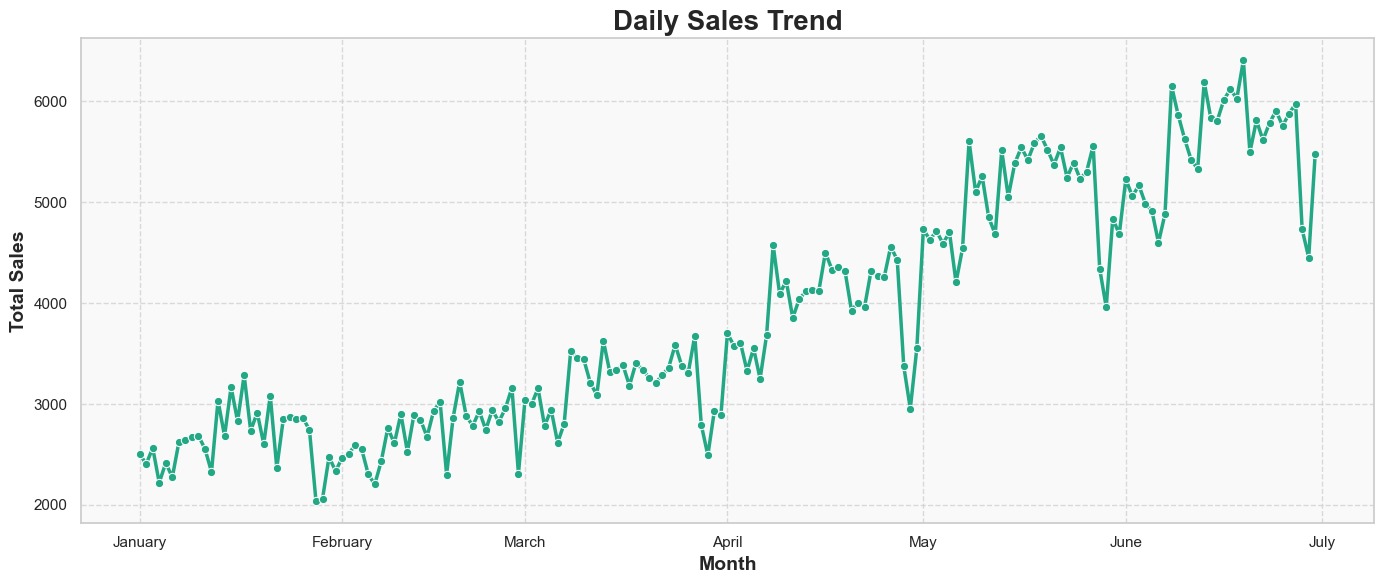

In [8]:
df1 = df.copy()
df1['transaction_time'] = df1['transaction_time'].apply(lambda t: pd.Timedelta(hours=t.hour, minutes=t.minute, seconds=t.second))
df1['transaction_datetime'] = df1['transaction_date'] + df1['transaction_time']

df1['date'] = df1['transaction_datetime'].dt.date
df1['year'] = df1['transaction_datetime'].dt.year
df1['month'] = df1['transaction_datetime'].dt.month
df1['week'] = df1['transaction_datetime'].dt.isocalendar().week
df1['day_of_week'] = df1['transaction_datetime'].dt.dayofweek
df1['hour'] = df1['transaction_datetime'].dt.hour
df1['day_name'] = df1['transaction_datetime'].dt.day_name()

df1['sales'] = df1['transaction_qty'] * df1['unit_price']

daily_sales = df1.groupby('date')['sales'].sum()

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1)

start = daily_sales.index.min().replace(day=1)
end = (daily_sales.index.max() + pd.offsets.MonthBegin(1)).replace(day=1)
xticks = pd.date_range(start=start, end=end, freq='MS')
xtick_labels = [dt.strftime('%B') for dt in xticks]

plt.figure(figsize=(14, 6))
sns.lineplot(
    x=daily_sales.index,
    y=daily_sales.values,
    linewidth=2.5,
    marker='o',
    color=sns.color_palette("viridis", as_cmap=True)(0.6)
)
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=0)
plt.title('Daily Sales Trend', fontsize=20, weight='bold')
plt.xlabel('Month', fontsize=14, weight='bold')
plt.ylabel('Total Sales', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor("#f9f9f9")
plt.tight_layout()
plt.show()

#### Sales by Day of the Week

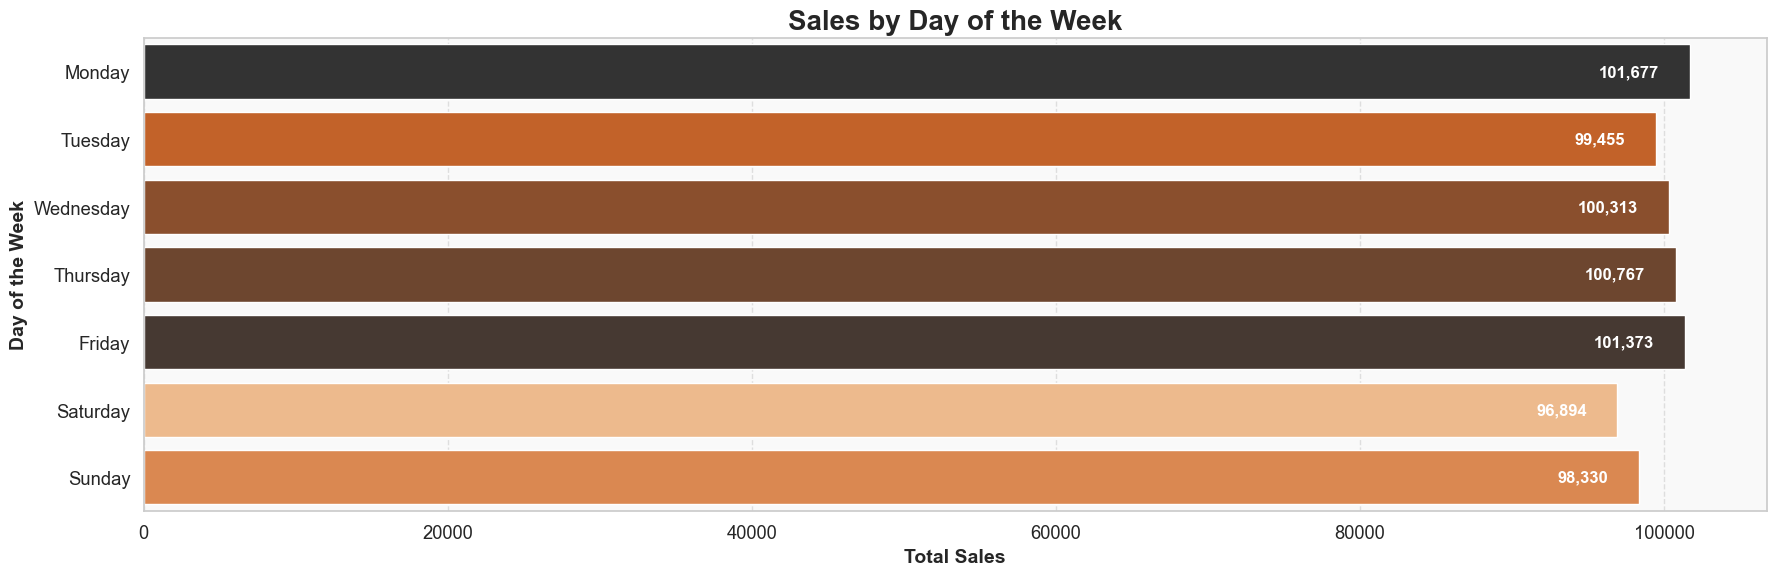

In [9]:
dow_sales = df1.groupby('day_of_week')['sales'].sum().reset_index()
dow_sales['day_name'] = dow_sales['day_of_week'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

dow_sales = dow_sales.sort_values(by='day_of_week')

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

plt.figure(figsize=(18, 6))
barplot = sns.barplot(
    y='day_name',
    x='sales',
    hue='sales',
    legend=False,
    data=dow_sales,
    palette='Oranges_d'
)

for i, row in dow_sales.iterrows():
    plt.text(row['sales'] * 0.98, i, f"{int(row['sales']):,}",
             va='center', ha='right', fontsize=12, weight='bold', color='white')

plt.title('Sales by Day of the Week', fontsize=20, weight='bold')
plt.xlabel('Total Sales', fontsize=14, weight='bold')
plt.ylabel('Day of the Week', fontsize=14, weight='bold')
plt.xticks(rotation=0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().set_facecolor("#f9f9f9")
plt.tight_layout()
plt.show()

#### Sales by Hour of Day

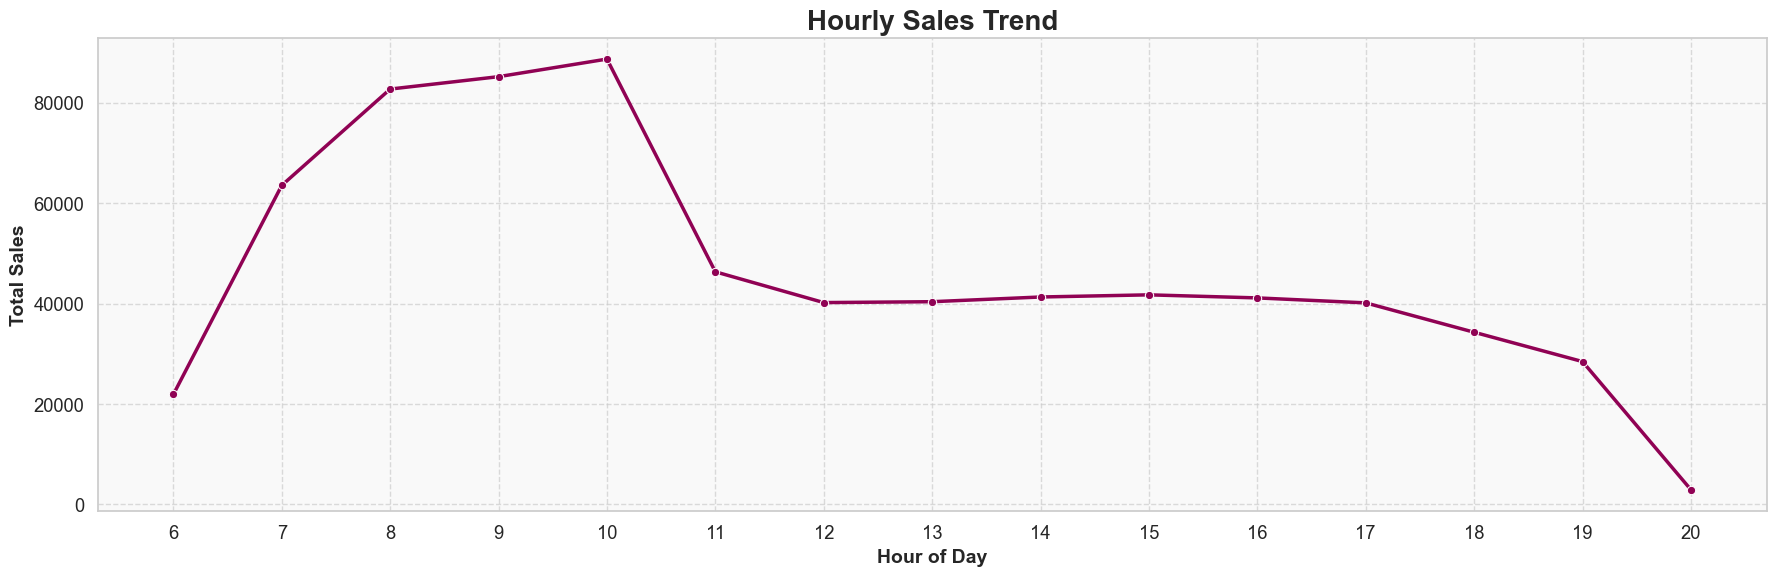

In [10]:
hourly_sales = df1.groupby('hour')['sales'].sum().reset_index()
hourly_sales = hourly_sales.sort_values(by='hour')
plotted_hours = hourly_sales['hour'].tolist()

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

plt.figure(figsize=(18, 6))
sns.lineplot(
    x='hour',
    y='sales',
    data=hourly_sales,
    marker='o',
    linewidth=2.5,
    color=sns.color_palette("PiYG", as_cmap=True)(1)
)
plt.xticks(ticks=plotted_hours, labels=[str(h) for h in plotted_hours], rotation=0)
plt.title('Hourly Sales Trend', fontsize=20, weight='bold')
plt.xlabel('Hour of Day', fontsize=14, weight='bold')
plt.ylabel('Total Sales', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor("#f9f9f9")
plt.tight_layout()
plt.show()

#### Sales Heatmap

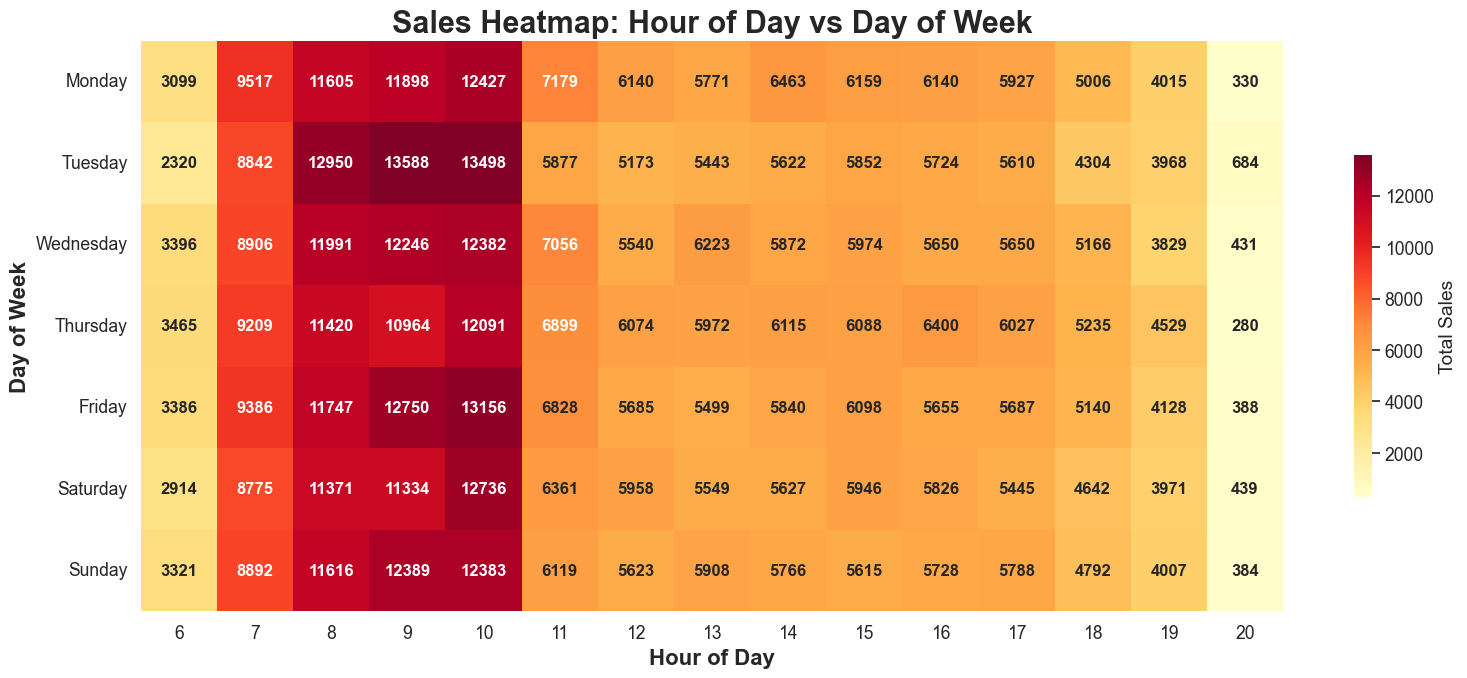

In [11]:
pivot = df1.pivot_table(values='sales', index='day_name', columns='hour', aggfunc='sum').fillna(0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(days_order)

sns.set_theme(style="darkgrid", palette="rocket", font_scale=1.15)

plt.figure(figsize=(16, 7))
ax = sns.heatmap(
    pivot,
    cmap="YlOrRd",
    annot=True,
    fmt=".0f",
    annot_kws={"size":12, "weight":"bold"},
    cbar_kws={'label': 'Total Sales', 'shrink': 0.6}
)
plt.title('Sales Heatmap: Hour of Day vs Day of Week', fontsize=22, weight='bold')
plt.xlabel('Hour of Day', fontsize=16, weight='bold')
plt.ylabel('Day of Week', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

#### Sales by Product Category

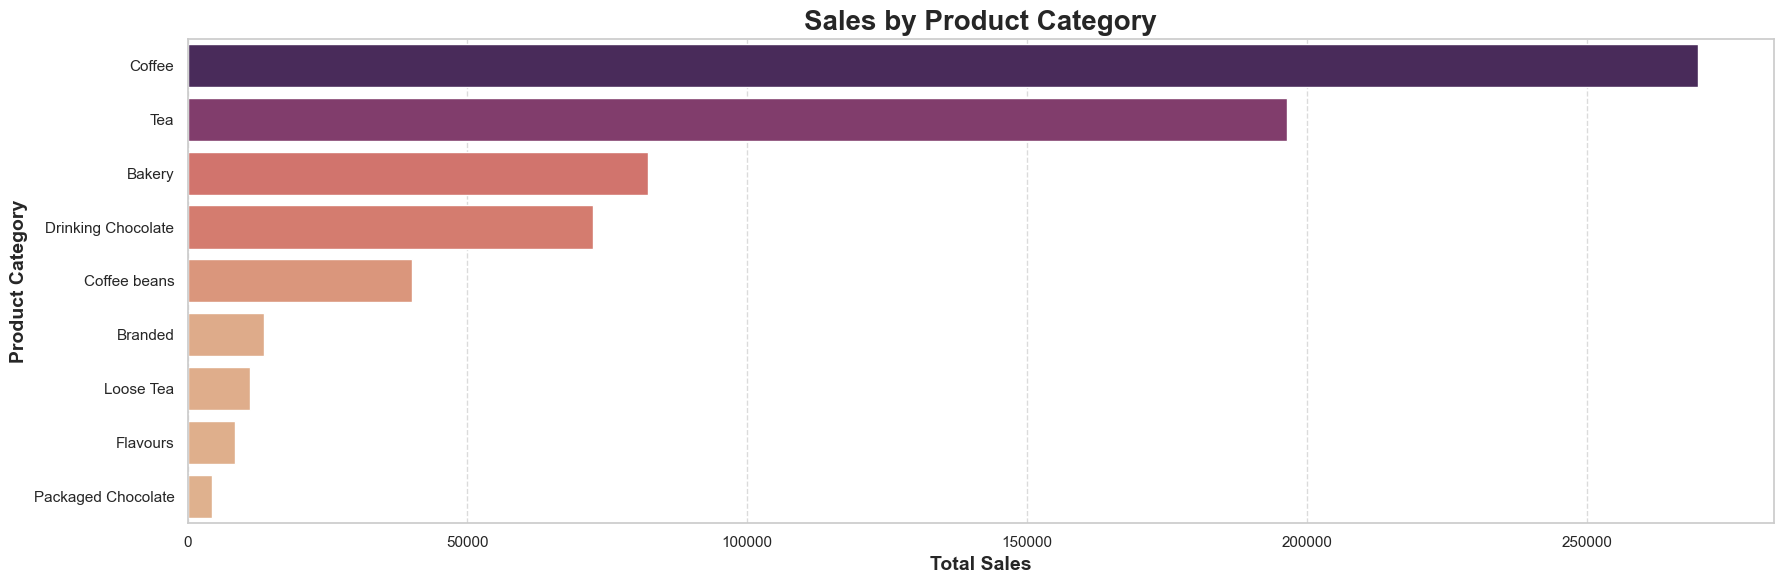

In [12]:
category_sales = df1.groupby('product_category')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

sns.set_theme(style="whitegrid", palette="viridis", font_scale=1)

plt.figure(figsize=(18, 6))
barplot = sns.barplot(
    x='sales',
    y='product_category',
    hue='sales',
    legend=False,
    data=category_sales,
    palette='flare',
)

plt.title('Sales by Product Category', fontsize=20, weight='bold')
plt.xlabel('Total Sales', fontsize=14, weight='bold')
plt.ylabel('Product Category', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Sales by Product Type

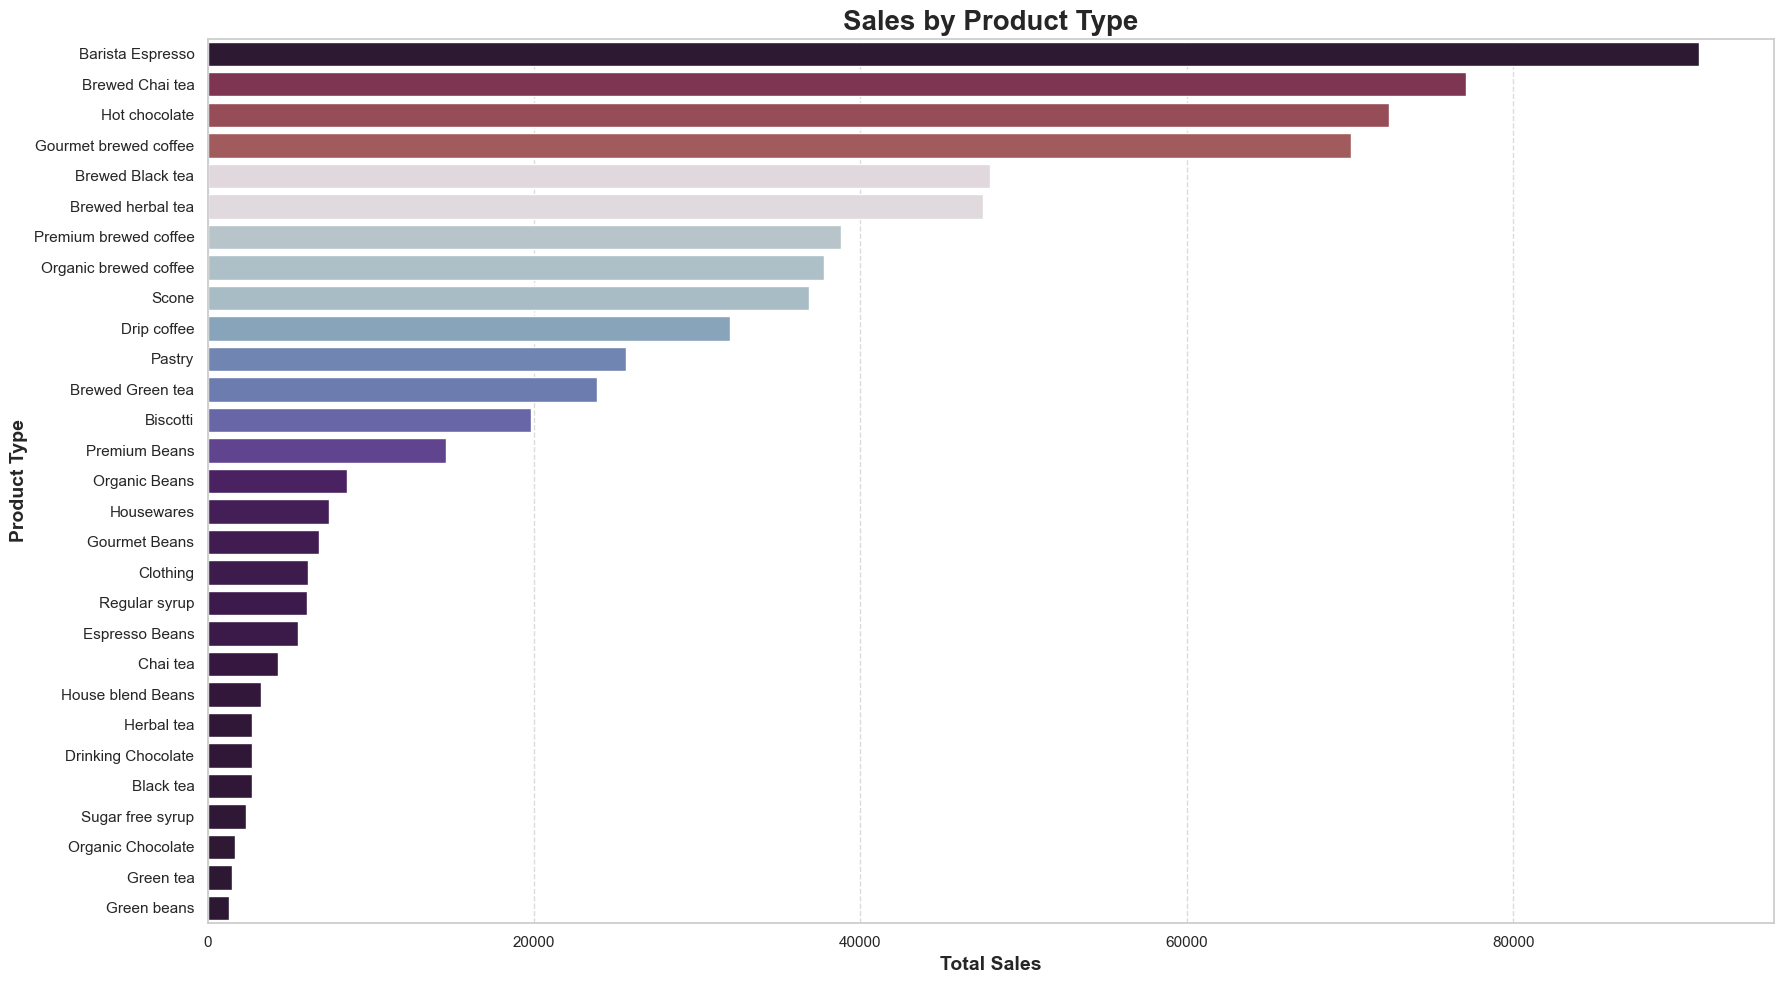

In [13]:
type_sales = df1.groupby('product_type')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

sns.set_theme(style="whitegrid", palette="viridis", font_scale=1)

plt.figure(figsize=(18, 10))
sns.barplot(
    x='sales',
    y='product_type',
    hue='sales',
    legend=False,
    data=type_sales,
    palette='twilight_shifted',
)
plt.title('Sales by Product Type', fontsize=20, weight='bold')
plt.xlabel('Total Sales', fontsize=14, weight='bold')
plt.ylabel('Product Type', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Top-20 Revenue Generating Products

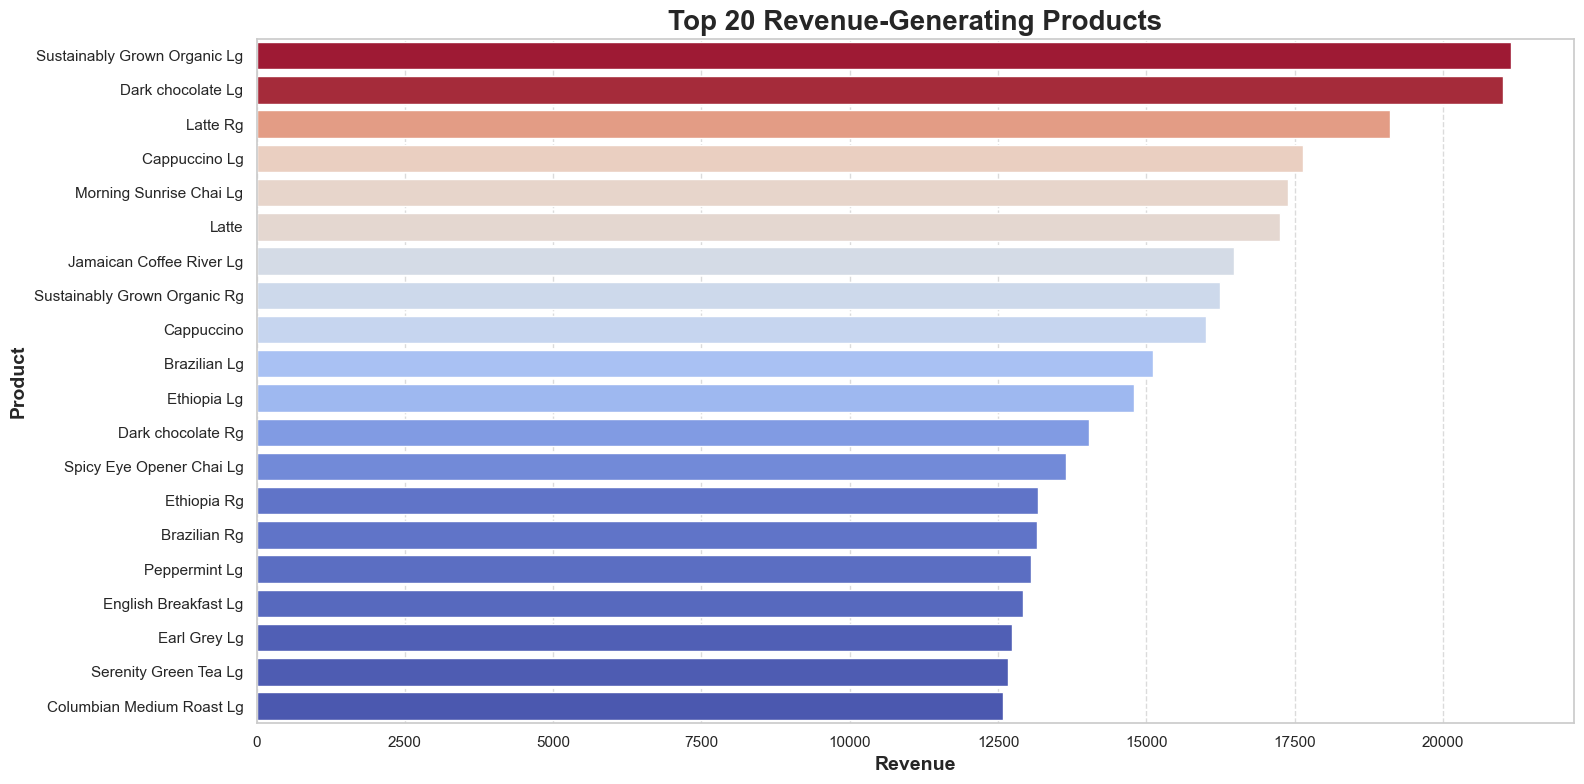

In [14]:
top_products = df1.groupby('product_detail')['sales'].sum().sort_values(ascending=False).head(20).reset_index()

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1)

plt.figure(figsize=(16, 8))
sns.barplot(
    y='product_detail',
    x='sales',
    hue='sales',
    legend=False,
    data=top_products,
    palette='coolwarm'
)
plt.title('Top 20 Revenue-Generating Products', fontsize=20, weight='bold')
plt.xlabel('Revenue', fontsize=14, weight='bold')
plt.ylabel('Product', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Top 20 Most Frequently Purchased Products

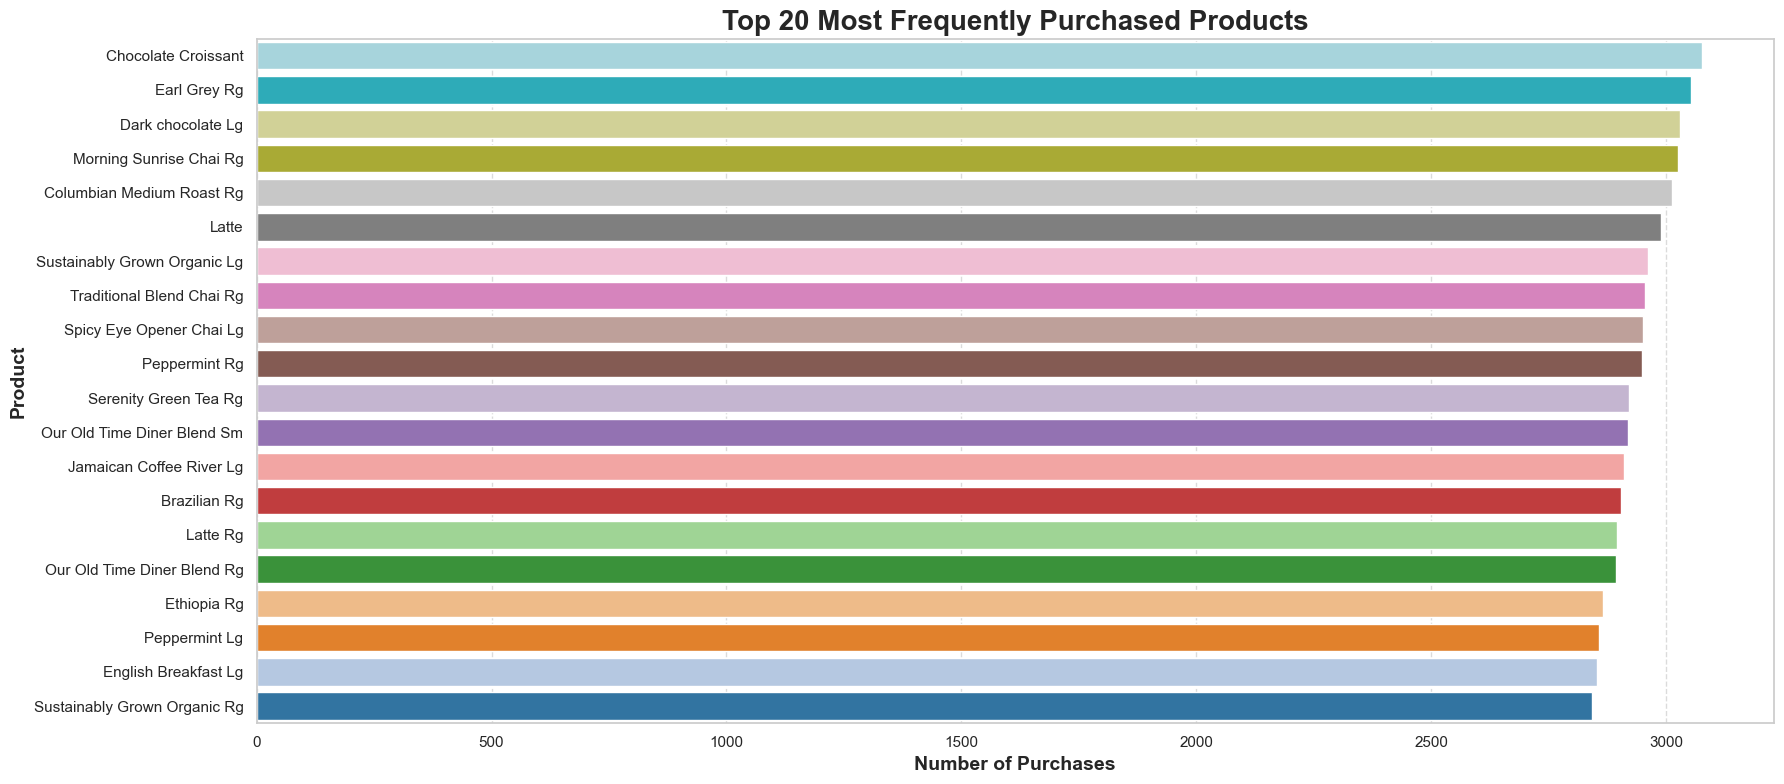

In [15]:
freq_products = df1.groupby('product_detail')['transaction_id'].count().reset_index(name='count')
freq_products = freq_products.sort_values(by='count', ascending=False).head(20)

sns.set_theme(style="whitegrid", palette="viridis", font_scale=1)

plt.figure(figsize=(18, 8))
sns.barplot(
    data=freq_products,
    y='product_detail',
    x='count',
    hue='count',
    legend=False,
    palette='tab20',
)
plt.title('Top 20 Most Frequently Purchased Products', fontsize=20, weight='bold')
plt.xlabel('Number of Purchases', fontsize=14, weight='bold')
plt.ylabel('Product', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Product Category Preference by Hour

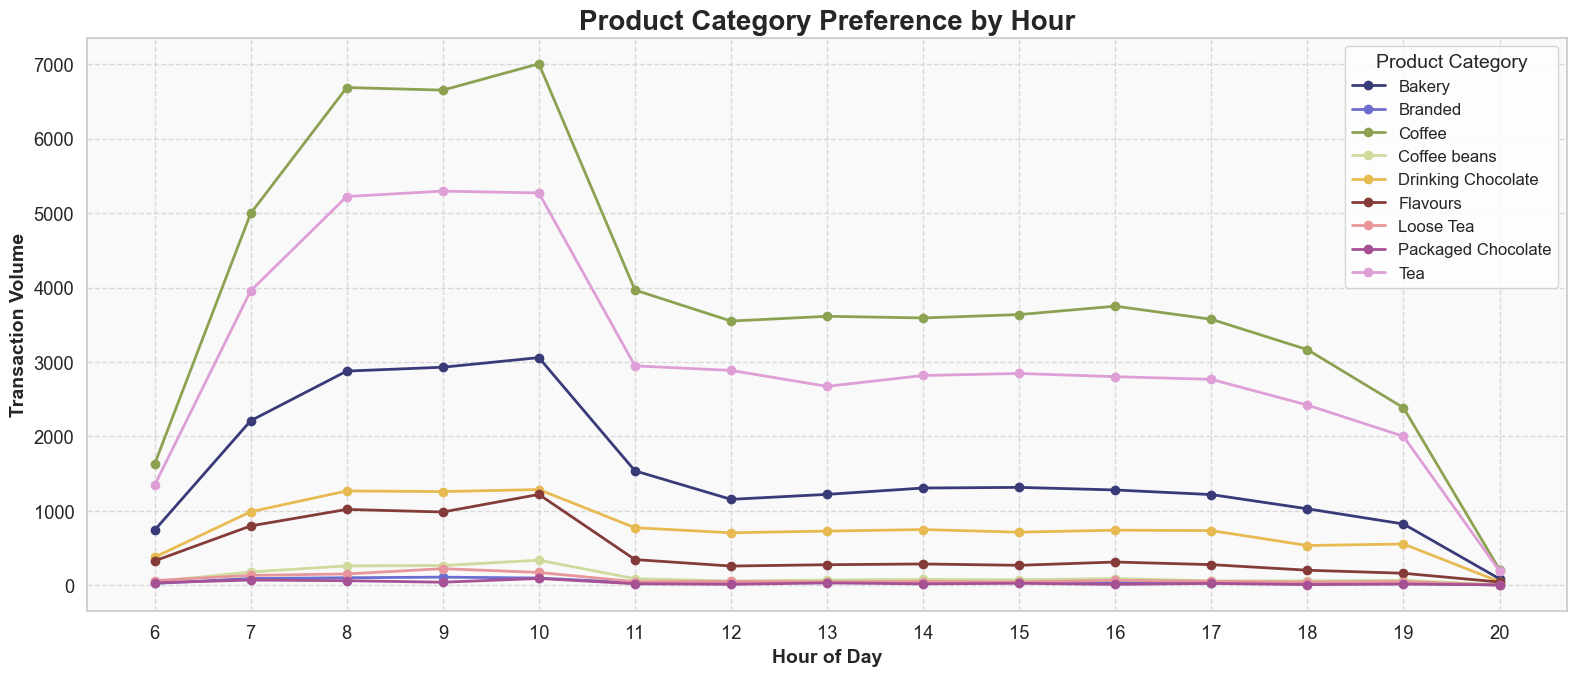

In [16]:
category_hour = df1.groupby(['hour', 'product_category'])['transaction_id'].count().reset_index()
category_pivot = category_hour.pivot(index='hour', columns='product_category', values='transaction_id').fillna(0)

sns.set_theme(style="whitegrid", font_scale=1.2)

ax = category_pivot.plot(
    kind='line',
    marker='o',
    linewidth=2,
    colormap='tab20b',
    figsize=(16, 7)
)
plt.title('Product Category Preference by Hour', fontsize=20, weight='bold')
plt.xlabel('Hour of Day', fontsize=14, weight='bold')
plt.ylabel('Transaction Volume', fontsize=14, weight='bold')
plt.xticks(ticks=category_pivot.index, labels=category_pivot.index, rotation=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor("#f9f9f9")
plt.legend(title='Product Category', fontsize=12, title_fontsize=14, loc='upper right')
plt.tight_layout()
plt.show()

In [19]:
df1['combo_id'] = df1['transaction_date'].astype(str) + '_' + \
                 df1['transaction_time'].astype(str) + '_' + \
                 df1['store_id'].astype(str) + '_' + \
                 df1['store_location']

combo_df = df1.groupby('combo_id')['product_detail'].apply(list).reset_index()

te = TransactionEncoder()
te_ary = te.fit(combo_df['product_detail']).transform(combo_df['product_detail'])
basket_encoded = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(basket_encoded, min_support=0.002, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

rules = rules[(rules['confidence'] >= 0.1) & (rules['lift'] >= 1.0)]
rules = rules.sort_values(by='lift', ascending=False)

display_df = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
display_df['antecedents'] = display_df['antecedents'].apply(lambda x: ', '.join(list(x)))
display_df['consequents'] = display_df['consequents'].apply(lambda x: ', '.join(list(x)))

table = display_df.head(10).style \
    .format({
        'support': '{:.3f}',
        'confidence': '{:.2f}',
        'lift': '{:.2f}'
    }) \
    .set_properties(**{'font-size': '12pt', 'font-family': 'Calibri'}) \
    .hide(axis='index')
table

antecedents,consequents,support,confidence,lift
Ouro Brasileiro shot,Ginger Scone,0.006,0.31,15.82
Ginger Scone,Ouro Brasileiro shot,0.006,0.30,15.82
Hazelnut syrup,Latte Rg,0.003,0.24,9.87
Latte Rg,Hazelnut syrup,0.003,0.13,9.87
Cappuccino,Sugar Free Vanilla syrup,0.003,0.14,9.22
Sugar Free Vanilla syrup,Cappuccino,0.003,0.22,9.22
Chocolate syrup,Cappuccino Lg,0.003,0.22,9.22
Cappuccino Lg,Chocolate syrup,0.003,0.14,9.22
Latte Rg,Chocolate syrup,0.003,0.13,9.08
Chocolate syrup,Latte Rg,0.003,0.22,9.08
